## 1. Import Libraries & Data

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

/opt/miniconda3/envs/myenv_practice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Exploratory Data Analysis

In [3]:
df_house_price = pd.read_csv("Data/house-prices-advanced-regression-techniques/train.csv")
print(df_house_price.info())
df_house_price.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Profile Columns
target_col = "SalePrice"
print("Target Column:", target_col,"\n")

na_code = "None"
# Ordinal Columns
common_ordinal_scale_1 = [na_code,"Po","Fa","TA","Gd","Ex"]
ordinal_col_common_scale_1 = ["ExterQual","ExterCond","BsmtQual","BsmtCond",
                            "HeatingQC","KitchenQual","FireplaceQu",
                            "GarageQual","GarageCond","PoolQC"]

common_ordinal_scale_2 = [na_code, "Unf", "LwQ", "Rec", "BLQ","ALQ","GLQ"]
ordinal_col_common_scale_2 = ["BsmtFinType1","BsmtFinType2"]

ordinal_col_custom_scale = {
                "LotShape":[na_code,"Reg","IR1","IR2","IR3"]
               ,"LandSlope": [na_code, "Gtl","Mod","Sev"]
               ,"BsmtExposure": [na_code,"No","Mn","Av","Gd"]
               ,"Functional" : [na_code,"Sal","Sev","Maj2","Maj1","Mod","Min2","Min1","Typ"]
               ,"GarageFinish" : [na_code,"Unf","RFn","Fin"]
               ,"Fence" : [na_code,"MnWw","GdWo","MnPrv","GdPrv"]
               }

ordinal_col_encoded = ["OverallCond", "OverallQual"]

nominal_col = {
                "MSZoning":[na_code, "A","C (all)","FV","I","RH","RL","RP","RM"]
               ,"Street":[na_code,"Grvl","Pave"]
               ,"Alley":[na_code,"Grvl","Pave"]
               ,"LandContour":[na_code,"Lvl","Bnk","HLS","Low"]
               ,"Utilities": [na_code,"AllPub","NoSewr","NoSeWa","ELO"]
               ,"LotConfig": [na_code,"Inside","Corner","CulDSac","FR2","FR3" ]
               ,"Neighborhood": [na_code,"Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR","MeadowV","Mitchel","NAmes","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr","Timber","Veenker"]
               ,"Condition1": [na_code,"Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"]
               ,"Condition2": [na_code,"Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"]
               ,"BldgType": [na_code,"1Fam","2fmCon","Duplex","TwnhsE","TwnhsI","Twnhs"]
               ,"HouseStyle": [na_code,"1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl"]
               ,"RoofStyle": [na_code,"Flat","Gable","Gambrel","Hip","Mansard","Shed"]
               ,"RoofMatl" : [na_code,"ClyTile","CompShg","Membran","Metal","Roll","Tar&Grv","WdShake","WdShngl" ]
               ,"Exterior1st" : [na_code,"AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing" ]
               ,"Exterior2nd" : [na_code,"AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing" ]
               ,"MasVnrType" : ["None","BrkCmn", "BrkFace","CBlock","Stone"]
               ,"Foundation" : [na_code,"BrkTil","CBlock","PConc","Slab","Stone","Wood"]
               ,"Heating" : [na_code,"Floor","GasA","GasW","Grav","OthW","Wall"]
               ,"CentralAir" : [na_code, "N","Y"]
               ,"Electrical" : [na_code,"SBrkr","FuseA","FuseF","FuseP","Mix" ]
               ,"PavedDrive" : [na_code, "Y", "P", "N" ]
               ,"GarageType" : [na_code,"2Types","Attchd","Basment","BuiltIn","CarPort","Detchd"]
               ,"MiscFeature" : [na_code,"Elev","Gar2","Othr","Shed","TenC","NA"]
               ,"SaleType" : ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"]
               ,"SaleCondition" : [na_code,"Normal","Abnorml","AdjLand","Alloca","Family","Partial"]
               }

# Categorical Columns
categorical_col = [i for i in df_house_price.select_dtypes(include="object").columns.to_list()
                    if i not in ["Id", target_col] ] + ordinal_col_encoded
print("Categorical Columns:", len(categorical_col))
print("Ordinal - Scale",common_ordinal_scale_1,":",len(ordinal_col_common_scale_1))
print("Ordinal - Scale",common_ordinal_scale_2,":",len(ordinal_col_common_scale_2))
print("Ordinal - Custom Scale : ", len(list(ordinal_col_custom_scale.keys()) + ordinal_col_encoded))
print("Nominal : ", len(nominal_col))


# Numerical Columns
print()
numerical_col = [i for i in df_house_price.select_dtypes(exclude="object").columns.to_list()
                 if i not in ["Id", target_col, "OverallCond", "OverallQual"]]
print("Numerical Columns:", len(numerical_col))
print(numerical_col)

Target Column: SalePrice 

Categorical Columns: 45
Ordinal - Scale ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] : 10
Ordinal - Scale ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'] : 2
Ordinal - Custom Scale :  8
Nominal :  25

Numerical Columns: 34
['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [5]:
null_values = df_house_price.isnull().sum()
df_house_price.dtypes.rename("Data Type").to_frame()\
    .join(null_values[null_values>0].rename("Null Count"), how="inner")\
    .sort_values(["Data Type","Null Count"])
df_house_price.replace({"Wd Shng":'WdShing',
                        "CmentBd":'CemntBd',
                        'Brk Cmn':"BrkComm"}, inplace=True)

### 2.1. Numerical Columns

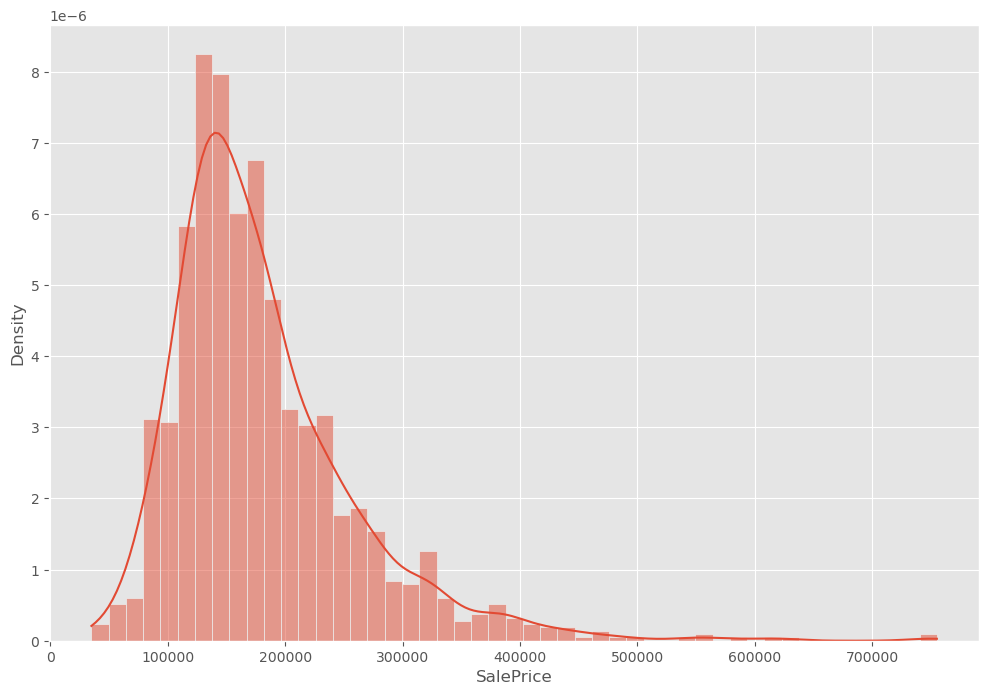

In [6]:
sns.histplot(df_house_price, x = target_col, stat="density", kde=True)
plt.show()

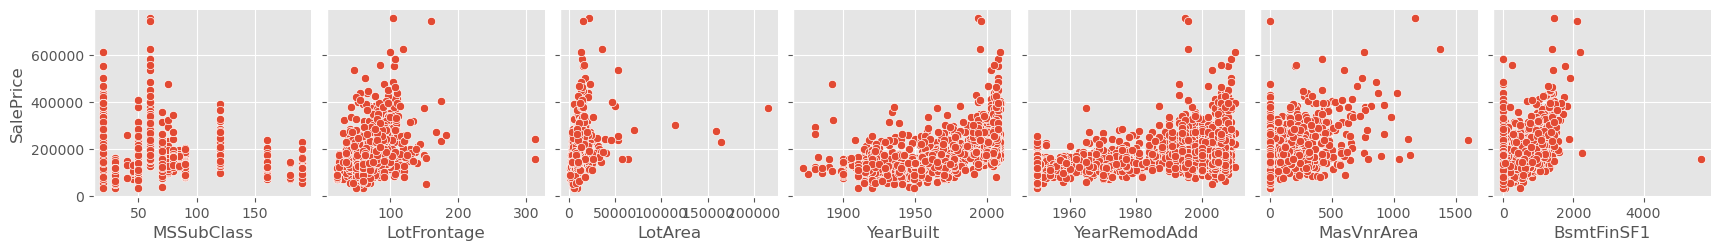

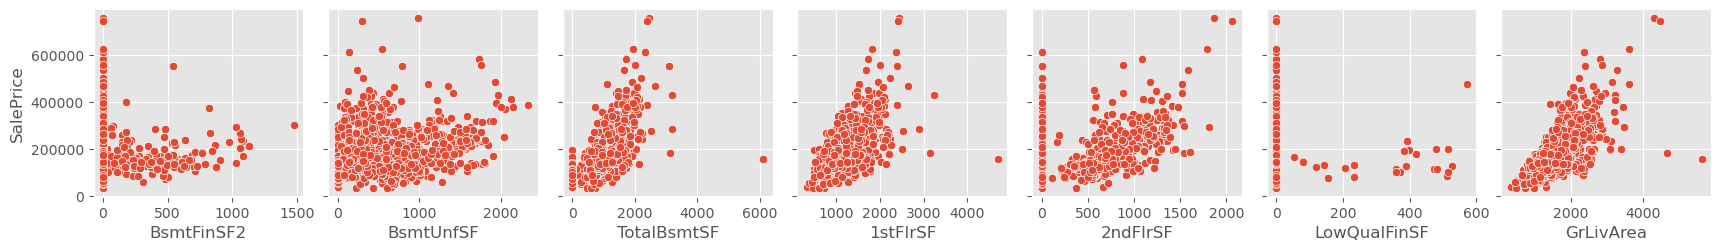

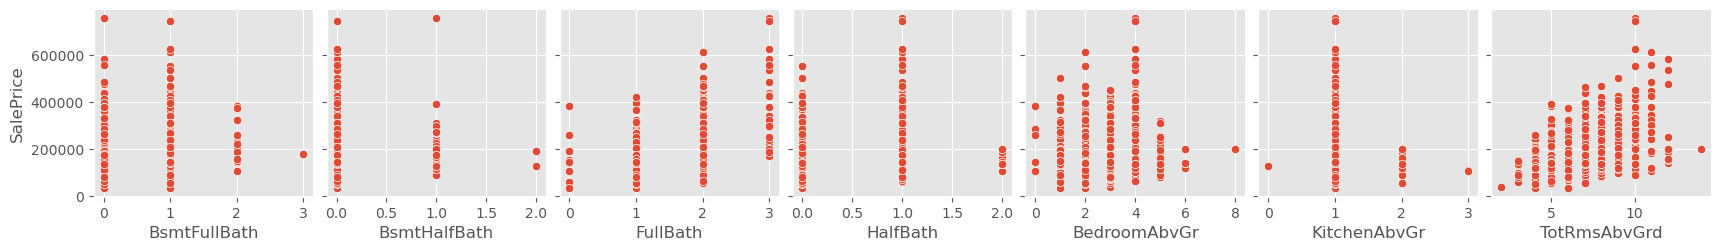

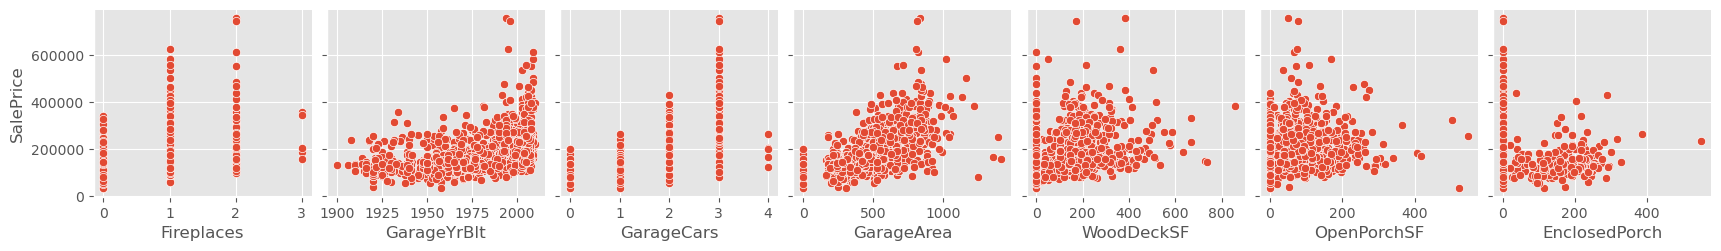

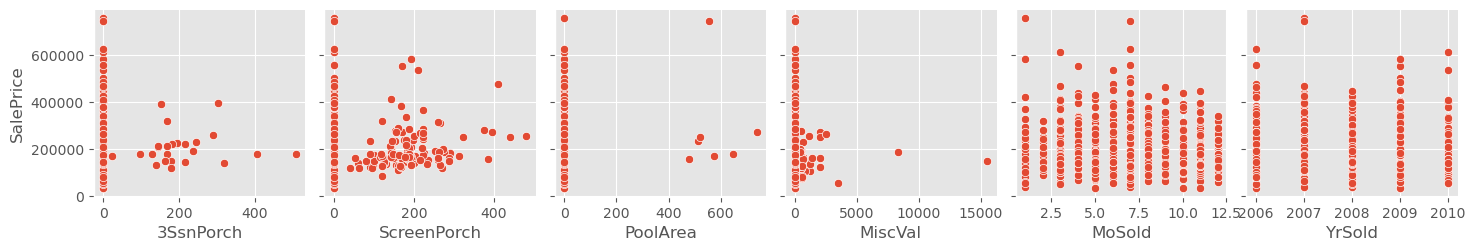

In [7]:
for i in np.arange(start=0,stop=35, step=7):
    i_end = i + 7
    if i_end > len(numerical_col):
        i_end = len(numerical_col)
    sns.pairplot(df_house_price, 
                 y_vars=[target_col], x_vars= numerical_col[i:i_end], 
                 diag_kind="kde")
plt.show()

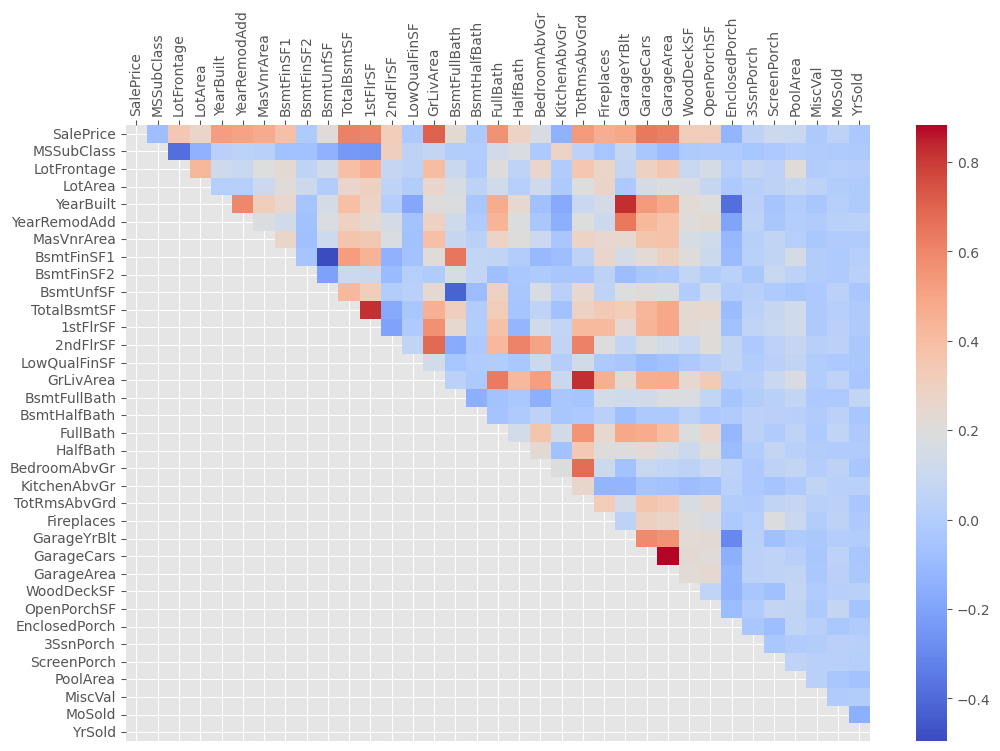

In [8]:
corr_matrix = df_house_price[ [target_col] + numerical_col].corr()
ax = sns.heatmap(corr_matrix, mask=np.tril(corr_matrix),  cmap="coolwarm")
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(rotation = 90)
plt.show()

### 2.2. Categorical Columns

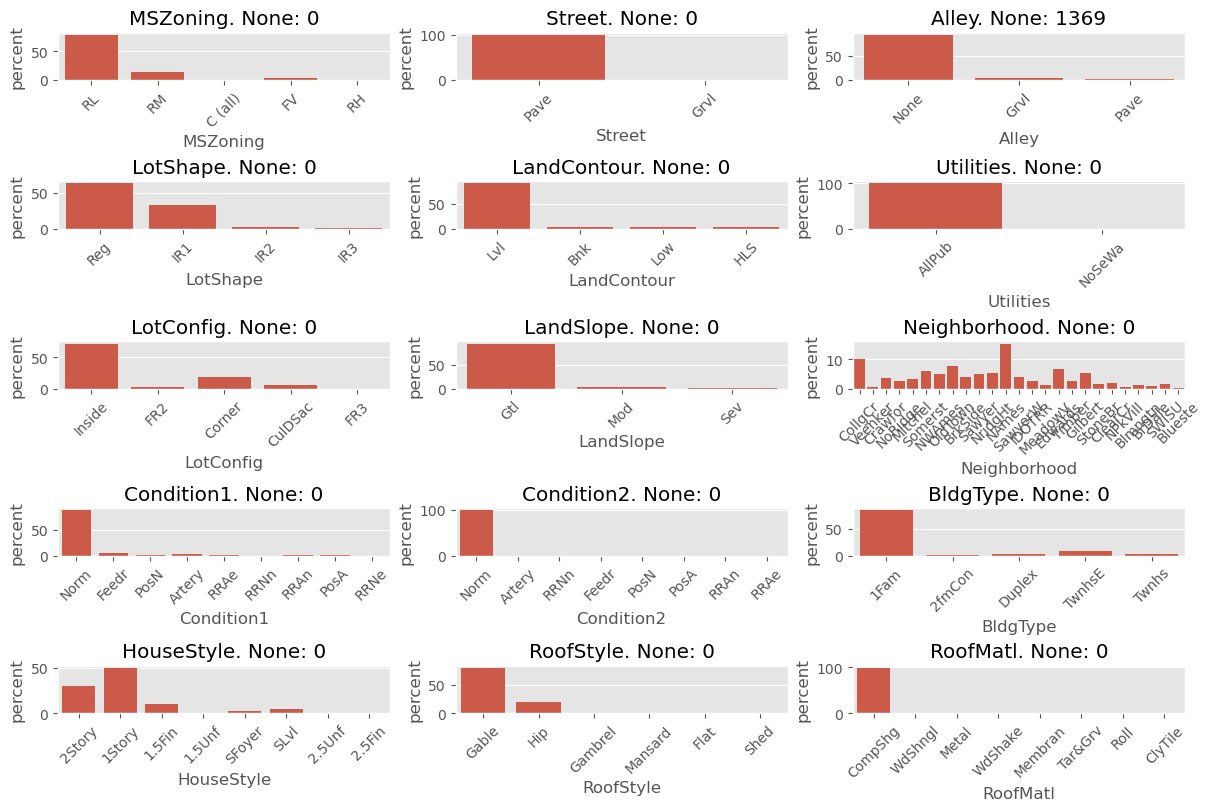

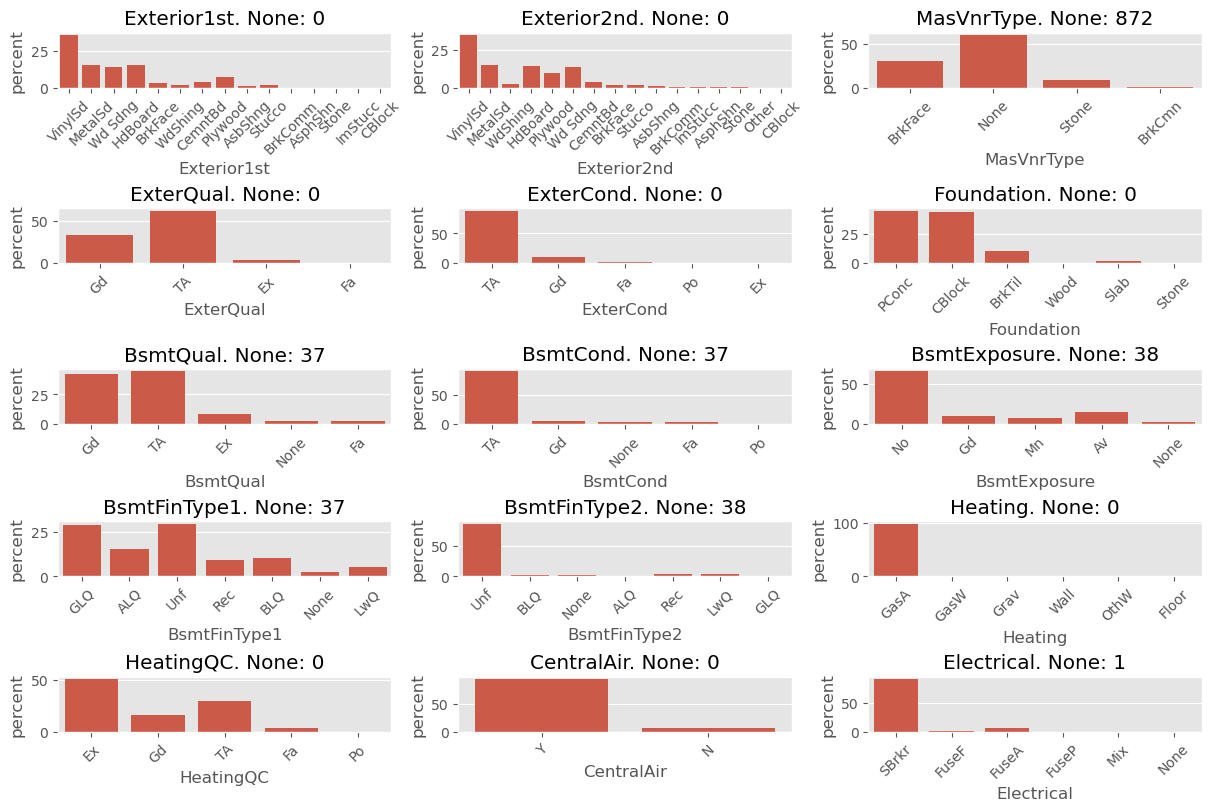

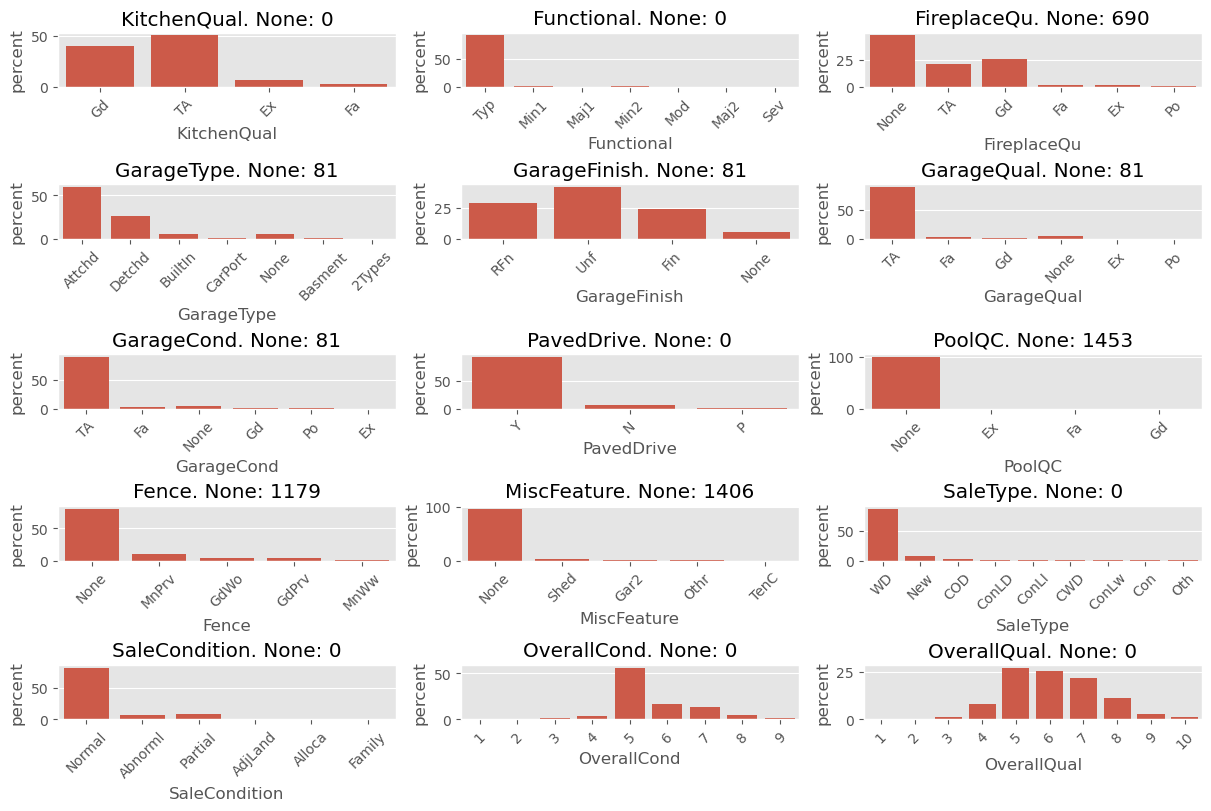

In [9]:
df_temp =  df_house_price[categorical_col].fillna("None")
for i in np.arange(start=0, stop=45 , step=15):
    fig, axes = plt.subplots(ncols=3,nrows=5, constrained_layout=True)
    axes = axes.ravel()
    for ax, col in zip(axes,categorical_col[i : min([i + 15,len(categorical_col)])] ):
        sns.countplot(df_temp,x=col, stat="percent", ax=ax)
        ax.set_title(f"{col}. None: {df_house_price[df_house_price[col].isnull()].shape[0]}")
        ax.xaxis.set_tick_params(rotation = 45)
plt.show()

In [10]:
X = df_house_price.drop(columns=["Id", target_col])
y = df_house_price[target_col].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=207)
print("Train Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Train Set Size: (1168, 79)
Test Set Size: (292, 79)


### 3. Model Building
#### 3.1. Build Pipeline

In [11]:
# Create Numeric Imputer
preprocessor_impute_numeric = ColumnTransformer(
    transformers=[
         ("imputer_numeric", SimpleImputer(strategy="median",keep_empty_features=True),make_column_selector(dtype_exclude="object") )
    ]
    ,remainder="passthrough"
    ,verbose_feature_names_out=False
    ).set_output(transform="pandas")

# Create String Imputer
preprocessor_impute_string = ColumnTransformer(
    transformers=[
         ("imputer_string", SimpleImputer(strategy="constant", fill_value=na_code,keep_empty_features=True),make_column_selector(dtype_include="object") )
    ]
    ,remainder="passthrough"
    ,verbose_feature_names_out=False
    ).set_output(transform="pandas")

# Create Encoder for Ordinal Columns with Common Scales
transformer_cat_ordinal_common_scale_1 = Pipeline(
    steps=[
        ("encoder_common_scale_1", 
         OrdinalEncoder(categories=np.repeat([common_ordinal_scale_1],len(ordinal_col_common_scale_1),axis=0).tolist()))
    ]
)

transformer_cat_ordinal_common_scale_2 = Pipeline(
    steps=[
        ("encoder_common_scale_2", 
         OrdinalEncoder(categories=np.repeat([common_ordinal_scale_2],len(ordinal_col_common_scale_2),axis=0).tolist()
                        ))
    ]
)

preprocessor_cat_ordinal_common_scale = ColumnTransformer(
    transformers=[
        ("transformer_cat_ordinal_common_scale_1", transformer_cat_ordinal_common_scale_1, ordinal_col_common_scale_1),
        ("transformer_cat_ordinal_common_scale_2", transformer_cat_ordinal_common_scale_2, ordinal_col_common_scale_2)
    ]
    ,remainder="passthrough"
)

# Create Encoder for Nominal Columns 
transformer_cat_nominal = ColumnTransformer(transformers=[]
                                                         ,remainder="passthrough"
                                                         ,verbose_feature_names_out=False).set_output(transform="pandas")

for col, cat in nominal_col.items():
    transformer_cat_nominal.transformers.append(
        [f"encoder_{col}", OneHotEncoder(categories=[cat], drop="first"), [col]]
    )


# Create Encoder for Ordinal Columns with Custom Scale
transformer_cat_ordinal_custom_scale = ColumnTransformer(transformers=[]
                                                         ,remainder="passthrough"
                                                         ,verbose_feature_names_out=False).set_output(transform="pandas")

for col, cat in ordinal_col_custom_scale.items():
    transformer_cat_ordinal_custom_scale.transformers.append(
        [f"encoder_{col}", OrdinalEncoder(categories=[cat]), [col]]
    )

# Set up Pre-processor Pipeline
pipeline_preprocessor = Pipeline(steps=
                                  [
                                        ('preprocessor_impute_numeric', preprocessor_impute_numeric)
                                        ,('preprocessor_impute_string', preprocessor_impute_string)
                                        ,('preprocessor_nominal', transformer_cat_nominal)
                                        ,('preprocessor_ordinal_custom_scale', transformer_cat_ordinal_custom_scale)
                                        ,('preprocessor_ordinal_common_scale', preprocessor_cat_ordinal_common_scale)
                                  ]
                                  )

# Set up Base Linear Regression Model
model_linear_regression = LinearRegression(fit_intercept=True)
pipeline_linear_regression = Pipeline(steps=
                                      [
                                          ('preprocessor', pipeline_preprocessor)
                                          ,('regressor_linear_regression', model_linear_regression)
                                      ]
                                      )
start = time.time()
pipeline_linear_regression.fit(X_train,y_train)
stop = time.time()
print(f"Training time - Linear Regresstion: {stop - start}s")

# Set up Base Gradient Boost Model
model_gradient_boost = GradientBoostingRegressor(loss="squared_error",
                                                 learning_rate=0.1,
                                                 n_estimators=100,
                                                 criterion="friedman_mse",
                                                 random_state=207)
pipeline_gradient_boost = Pipeline(steps=
                                      [
                                          ('preprocessor', pipeline_preprocessor)
                                          ,('regressor_gradient_boost', model_gradient_boost)
                                      ]
                                      )
start = time.time()
pipeline_gradient_boost.fit(X_train,y_train)
stop = time.time()
print(f"Training time - Gradient Boost: {stop - start}s")

# Set up Base Random Forest Model
model_random_forest_regressor = RandomForestRegressor(n_estimators=100,
                                                      criterion = "friedman_mse",
                                                      min_samples_split=2,
                                                      random_state=207)
pipeline_random_forest_regressor = Pipeline(steps=
                                      [
                                          ('preprocessor', pipeline_preprocessor)
                                          ,('regressor_gradient_boost', model_random_forest_regressor)
                                      ]
                                      )
start = time.time()
pipeline_random_forest_regressor.fit(X_train,y_train)
stop = time.time()
print(f"Training time - Random Forest: {stop - start}s")

Training time - Linear Regresstion: 0.08394694328308105s
Training time - Gradient Boost: 0.6747901439666748s
Training time - Random Forest: 1.464076042175293s


#### 3.2. Compare Performance

In [14]:
pipelines_dict = {"Linear Regression":pipeline_linear_regression,
                  "Random Forest Reg":pipeline_random_forest_regressor,
                  "Gradient Boosting Reg":pipeline_gradient_boost}
performance_data = []
for mdl, ppl in pipelines_dict.items():
    y_train_pred = ppl.predict(X_train)
    y_test_pred = ppl.predict(X_test)
    performance_data.append({
        "Set" : "Train",
        "Model" : mdl,
        "R-squared" : r2_score(y_train,y_train_pred),
        "MSE" : mean_squared_error(y_train,y_train_pred)
    })
    performance_data.append({
        "Set" : "Test",
        "Model" : mdl,
        "R-squared" : r2_score(y_test,y_test_pred),
        "MSE" : mean_squared_error(y_test,y_test_pred)
    })
performance_df = pd.DataFrame(data=performance_data)
performance_df["RMSE"] = np.sqrt(performance_df["MSE"])

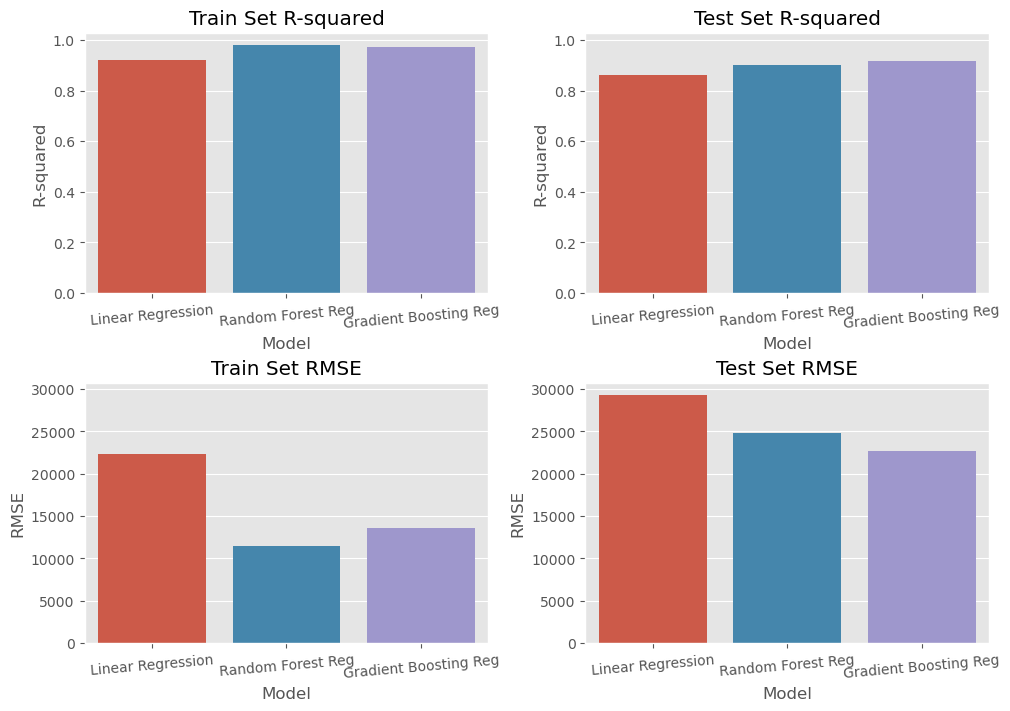

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, 
                         layout ="constrained",
                         figsize=(10,7))

for ax, metric_name in zip(axes,["R-squared","RMSE"]):
    sns.barplot(performance_df[performance_df["Set"]=="Train"], 
                        x = "Model", y = metric_name, hue = "Model",
                        ax=ax[0])
    ax[0].xaxis.set_tick_params(labelrotation=5)
    ax[0].set_title(f"Train Set {metric_name}")
    sns.barplot(performance_df[performance_df["Set"]=="Test"], 
                        x = "Model", y = metric_name, hue = "Model",
                        ax=ax[1])
    ax[1].xaxis.set_tick_params(labelrotation=5)
    ax[1].set_title(f"Test Set {metric_name}")
    
    if ax[0].get_ylim() > ax[1].get_ylim():
        ax[1].sharey(ax[0])
    else:
        ax[0].sharey(ax[1])
    
    
plt.show()

#### 3.3. Analyze Learning Curves and Validation Curves

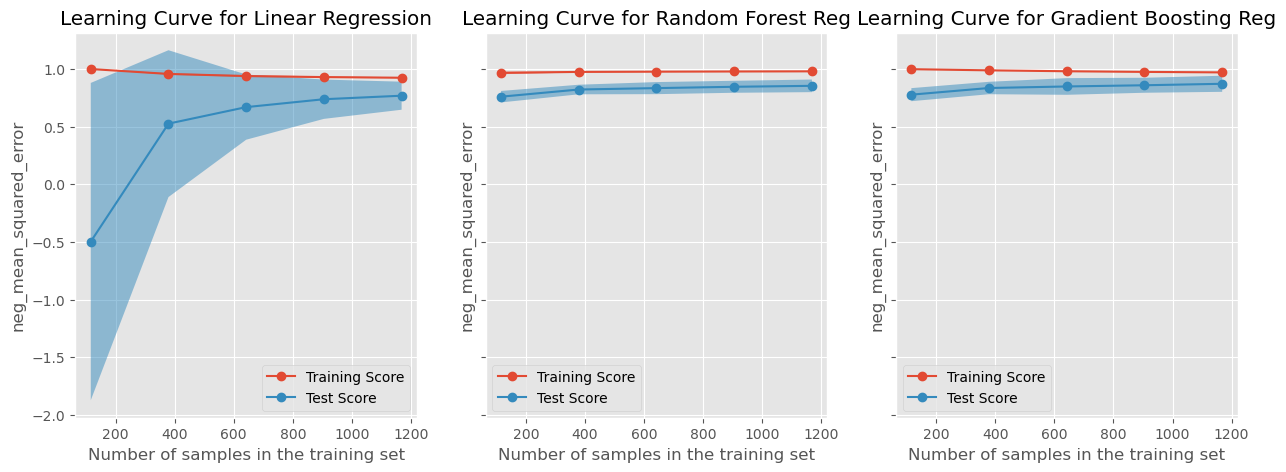

In [16]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=3, 
                       figsize=(15, 5), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=207),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "neg_mean_squared_error",
}

for ax_idx, (mdl , ppl) in zip(range(3),pipelines_dict.items()):
    LearningCurveDisplay.from_estimator(ppl, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {mdl}")